# Source Panel Method - 4/12/18

In [2]:
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy import integrate
%matplotlib inline

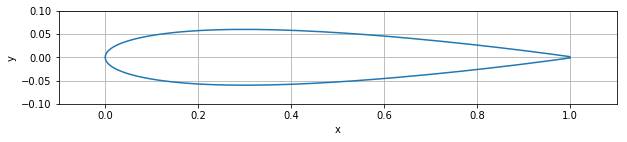

In [3]:
# read data file
naca0012 = os.path.join('resources', 'naca0012.dat')
with open (naca0012, 'r') as file_name:
    x, y = np.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)

width = 10
plt.figure(figsize = (width,width))
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1,0.1)
plt.plot(x,y)

### Discretize into panels

In [39]:
class Panel:
    
    def __init__(self,xa,ya,xb,yb):
        
        self.xa, self.ya = xa,ya
        self.xb, self.yb = xb,yb
        
        self.xc, self.yc = (xa+xb)/2,(ya+yb)/2
        self.length = np.sqrt((xb-xa)**2+(yb-ya)**2)
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
            
        self.sigma = 0.0  # source strength
        self.ut = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient
        
        # location of the panel
        if self.beta <= np.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'

In [40]:
#x coordinates are used to project circle coordinates on airfoil

def define_panels(x, y, N=40):
    
    #coordinates of circle
    R = (x.max() - x.min()) / 2 
    x_center = (x.max() + x.min()) / 2 
    
    x_circle = x_center + R * np.cos(np.linspace(0.0, 2 * np.pi, N + 1))
    
    x_ends = np.copy(x_circle)  # projection of the x-coord on the surface
    y_ends = np.empty_like(x_ends)  # initialization of the y-coord Numpy array
    
    x, y = np.append(x, x[0]), np.append(y, y[0])  # extend arrays using numpy.append
    
    # computes the y-coordinate of end-points
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels

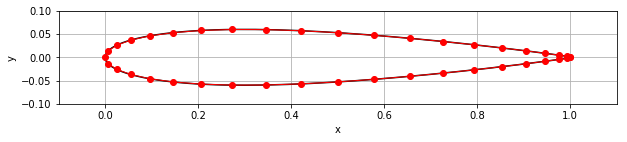

In [41]:
N=40 # number of panels
panels = define_panels(x,y,N)

width = 10
plt.figure(figsize = (width,width))
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1,0.1)
plt.plot(x,y, color='k')
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='r')

### Freestream conditions

airfoil emmersed in uniform flow with 0 aot

In [79]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)  # degrees --> radians

In [43]:
u_inf = 1.0
alpha = 0.0
freestream = Freestream(u_inf,alpha)

Flow Tangency Conditions (See lessons 9 and 10)

In [44]:
def integral(x, y, panel, dxdz, dydz):
   
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdz +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydz) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + np.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [45]:
def build_matrix(panels):
    N = len(panels)
    A = np.empty((N,N), dtype=float)
    np.fill_diagonal(A,0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(p_i.xc, p_i.yc, p_j,
                                                   np.cos(p_i.beta),
                                                   np.sin(p_i.beta))
    return A

def build_rhs(panels, freestream):
    
    b = np.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    
    return b

In [46]:
A = build_matrix(panels)
b = build_rhs(panels, freestream)
sigma = np.linalg.solve(A,b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

### Getting Pressure Coefficient

See lessons 9 and 10

In [65]:
def get_tangential_velocity(panels, freestream):
    
    N = len(panels)
    A = np.empty((N,N),dtype=float)
    np.fill_diagonal(A, 0.0)
    
    #populate A matrix
    for i,p_i in enumerate(panels):
        for j,p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(p_i.xc, p_i.yc, p_j,
                                                   -np.sin(p_i.beta),
                                                   np.cos(p_i.beta))
    
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    sigma = np.array([panel.sigma for panel in panels])
    
    ut = np.dot(A, sigma) + b
    
    for i,panel in enumerate(panels):
        panel.ut = ut[i]

In [66]:
#computes tangential velocity at the center point of each panel
get_tangential_velocity(panels, freestream)

In [67]:
def get_pressure_coefficient(panels, freestream):
    
    for panel in panels:
        panel.cp = 1.0 - (panel.ut / freestream.u_inf)**2

In [68]:
# computes the surface pressure coefficients
get_pressure_coefficient(panels, freestream)

### Theoretical Characteristics: Theodorsen's Method

In [69]:
voverVsquared=np.array([0.0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411,
                           1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044,
                           0.956, 0.906, 0.0])

CpTheo = 1-voverVsquared

xtheo=np.array([0.0, 0.5, 1.25, 2.5, 5.0, 7.5, 10.0, 15.0, 20.0, 25.0, 30.0,
                   40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 95.0, 100.0])

xtheo /= 100

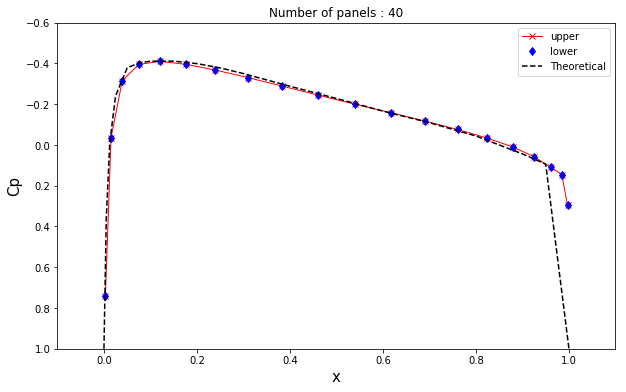

In [73]:
plt.figure(figsize=(10,6))
plt.plot([panel.xc for panel in panels if panel.loc == 'upper'], [panel.cp for panel in panels if panel.loc == 'upper'],
         label='upper',color = 'r',marker = 'x', linewidth = 1)
plt.plot([panel.xc for panel in panels if panel.loc =='lower'], [panel.cp for panel in panels if panel.loc == 'lower'],
            label='lower', color='b', marker='d',linewidth = 0)
plt.plot(xtheo,CpTheo,linestyle = '--',color='k',label = 'Theoretical')
plt.legend(loc ='best')
plt.xlabel('x',fontsize = 15)
plt.ylabel('Cp',fontsize = 15)
plt.xlim(-0.1, 1.1)
plt.ylim(1.0, -0.6)
plt.title('Number of panels : {}'.format(N));

#### Accuracy check

The sum the strength of the sources and the sinks need to be 0

In [74]:
accuracy = sum([panel.sigma*panel.length for panel in panels])
accuracy

0.0046170311752831037

### Plotting Streamlines onto Meshgrid

In [83]:
def get_velocity_field(panels,freestream,X,Y):
    
    #freestream contribution
    u = freestream.u_inf * np.cos(freestream.alpha) * np.ones_like(X, dtype=float)
    v = freestream.u_inf * np.sin(freestream.alpha) * np.ones_like(X, dtype=float)
    
    #contribution of each source
    vec_integral= np.vectorize(integral)
    
    for panel in panels:
        u+=panel.sigma / (2.*np.pi) * vec_integral(X,Y,panel,1.0,0.0)
        v+=panel.sigma / (2.*np.pi) * vec_integral(X,Y,panel,0.0,1.0)
    
    return u,v

In [85]:
nx, ny = 30, 30
x_start, x_end, y_start,y_end = -1.0,2.0,-0.3,0.3
x = np.linspace(x_start,x_end,nx)
y = np.linspace(y_start,y_end,ny)

X,Y = np.meshgrid(x,y)

u ,v = get_velocity_field(panels, freestream, X,Y)

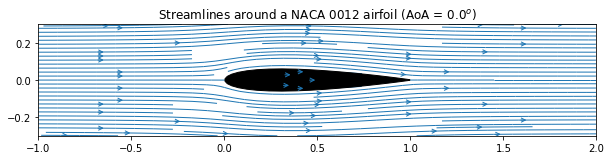

In [103]:
width = 10
plt.figure(figsize=(width,width))
plt.fill([panel.xc for panel in panels],[panel.yc for panel in panels], color = 'k', linestyle = 'solid',zorder = 2)
plt.streamplot(X,Y,u,v, density = 1, linewidth = 1, arrowstyle = '->', arrowsize=1)
plt.xlim(x_start,x_end)
plt.ylim(y_start,y_end)
plt.axis('scaled', adjustable = 'box')
plt.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(alpha));

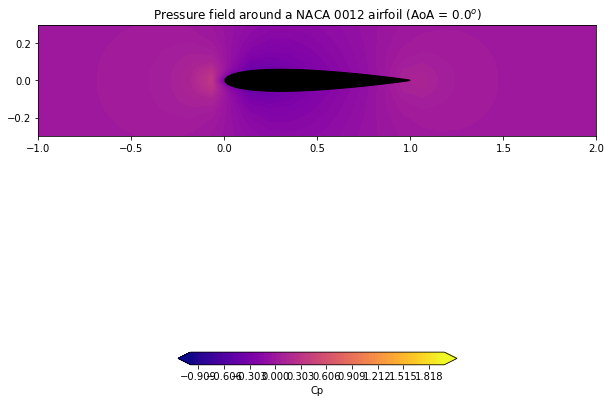

In [118]:
#compute pressure field

cp = 1.0 - (u**2+v**2)/freestream.u_inf**2

width = 10
plt.figure(figsize=(width,width))
plt.fill([panel.xc for panel in panels],[panel.yc for panel in panels], color = 'k', linestyle = 'solid',zorder = 2)
plt.contourf(X,Y,cp, levels = np.linspace(x_start,x_end,100),extend = 'both', cmap = 'plasma')
plt.colorbar(orientation = 'horizontal', shrink = 0.5, label = 'Cp')
plt.xlim(x_start,x_end)
plt.ylim(y_start,y_end)
plt.axis('scaled', adjustable = 'box')
plt.title('Pressure field around a NACA 0012 airfoil (AoA = ${}^o$)'.format(alpha));